In [2]:
SALIENCY_DIR = '/data/amartyadutta/crop_v_acc/'
MODEL_FLAG = 'original' # 'noisy'
# INPUT_FMT = 'crop_accumulate' ,'crop', 'mask', 'crop_mask'
size = 224
NUM_CROPS = 100
NUM_MASKS = 1
# if INPUT_FMT == 'crop_mask':
#     NUM_MASKS = 20
# else:
#     NUM_MASKS = 50

# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_crop/'
# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_binmask/'
# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_binmask_crop/'

In [3]:
from __future__ import print_function
import os
import sys
sys.path.append('../../')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch import multiprocessing, cuda
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.backends import cudnn
import seaborn as sns
import importlib
import os
from tqdm import tqdm
import voc12.dataloader
from misc import torchutils, imutils, myutils
import torchvision.transforms as transforms
from misc.myutils import unnormalize_image

In [4]:
GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,3'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 3


In [5]:
CLASSNAME_LIST = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train',
        'tvmonitor']

# Load Dataset

In [6]:
from chainercv.datasets import VOCSemanticSegmentationDataset
from chainercv.evaluations import calc_semantic_segmentation_confusion

# ground truth labels in gt_labels

gt_dataset = VOCSemanticSegmentationDataset(split="train",
                                            data_dir='/home/amartyadutta/VOC12/AMN/Datasets/VOCdevkit/VOC2012')

gt_labels = [gt_dataset.get_example_by_keys(i, (1,))[0] for i in range(len(gt_dataset))]


# segmentation dataset and data_loader 

dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(img_name_list_path='/home/amartyadutta/VOC12/AMN/voc12/train.txt',
                                                         voc12_root='/home/amartyadutta/VOC12/AMN/Datasets/VOCdevkit/VOC2012', 
                                                         scales=(1.0,))

data_loader = DataLoader(dataset, shuffle=False)


# NDR gt corresponds to non-deterministic region ground truths

ndr_gt_labels = [np.load(os.path.join('/raid/maruf/WSS/NDR_ground_truth', id + '.npy'), allow_pickle=True) for id in gt_dataset.ids]


# Load Model

In [7]:
model = getattr(importlib.import_module('net.resnet50_cam'), 'CAM_original')()

if MODEL_FLAG == 'original':
    model.load_state_dict(torch.load('/home/maruf/ws2m2/sess/res50_cam_original_version.pth' + '.pth', map_location='cpu'), strict=True)

elif MODEL_FLAG == 'noisy':
    model.load_state_dict(torch.load('/home/maruf/ws2m2/sess/res50_cam_bin_noise_version.pth' + '.pth', map_location='cpu'), strict=True)
    
model.eval()

model = model.cuda()

## RandomResize Crop Class

In [8]:
class MyCrop(torch.nn.Module):
    def __init__(self, size,scale,ratio):
        super().__init__()
        self.scale = scale
        self.ratio = ratio
        self.size = size
        
    def forward(self,img,crp = False):
        i, j, h, w  = transforms.RandomResizedCrop.get_params(img, self.scale, self.ratio)
        global_coordinates.append([i, j, h, w] )
        # print(i,j,h,w)
        return transforms.functional.resized_crop(img, i, j, h, w, self.size)
        # crp_img = transforms.functional.crop(img, i, j, h, w ).resize_(self.size)
        # return F.resized_crop(img, i, j, h, w  , self.size)
    

# SALIENCY

In [9]:
from torch.utils.data import Dataset

class RandomCropDataset(Dataset):
    def __init__(self, tensor, transform, size=1):
        self.tensor = tensor.squeeze(0)
        self.transform = transform
        self.size = size
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.transform(self.tensor)

t = transforms.Compose([
        MyCrop(
            (size,size),
            scale=(0.05, 0.3), 
            ratio=(0.85, 1.25)
        )
    ])
    
def get_saliencies(
    img_tensor,
    target_class,
    input_fmt='img',
    transform=t,
    num_crops = 100,
    num_masks = 50
):
    
    # print(num_crops)
    
    if input_fmt == 'img':
        
        model.zero_grad()
        
        img_tensor.requires_grad = True

        scores = model(img_tensor.type(dtype))

        combined_saliencies = []

        for class_idx in target_class:

            target_score = scores[:, class_idx]

            saliency = torch.autograd.grad(
                target_score, img_tensor,
                grad_outputs = torch.ones_like(target_score),
                retain_graph = True
            )[0]

            saliency = saliency.detach().abs().max(1)[0]
            combined_saliencies.append(saliency)

        raw_saliency = torch.cat(combined_saliencies).detach()
        
        return raw_saliency
        
    elif input_fmt == 'crop':
        
        img_tensor.requires_grad = True
        
        dataset = RandomCropDataset(img_tensor, transform, size=num_crops)
        dataloader = DataLoader(dataset, batch_size=100)

        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        real_saliencies = torch.zeros(num_crops, num_classes, size, size).type(dtype)

        for batch in dataloader:
            model.zero_grad()
            out = model(batch.type(dtype))
        
            for i, label in enumerate(target_class):
                label = label.long()
                target_val = out[:,label]
                weights = torch.sigmoid(target_val)
                
                
                #Saliency
                saliency = torch.autograd.grad(
                                        target_val, batch, 
                                        grad_outputs=weights,
                                        retain_graph=True
                                    )[0]
            
                saliency = saliency.detach().abs().max(1)[0]
                real_saliencies[:,i] += saliency.type(dtype)
                # real_saliencies[i] += saliency.type(dtype)
        
        # print(real_saliencies.shape)
        # raw_saliency = real_saliencies.squeeze(1).detach()
        # print(raw_saliency.shape)
        
        return batch, real_saliencies
    
    elif input_fmt == 'crop_accumulate':
        
        img_tensor.requires_grad = True
        
        dataset = RandomCropDataset(img_tensor, transform, size=num_crops)
        dataloader = DataLoader(dataset, batch_size=100)

        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        real_saliencies = torch.zeros(num_classes, 1, H, W).type(dtype)
        
        for batch in dataloader:
            model.zero_grad()
            out = model(batch.type(dtype))
            
            for i, label in enumerate(target_class):
                label = label.long()
                target_val = out[:,label]
                weights = torch.sigmoid(target_val)

                # Weighted Saliency
                saliency = torch.autograd.grad(
                                        target_val, img_tensor, 
                                        grad_outputs=weights,
                                        retain_graph=True
                                    )[0]
                saliency = saliency.detach().abs().max(1)[0]
                real_saliencies[i] += saliency.type(dtype)
        
        # print(real_saliencies.shape)
        raw_saliency = real_saliencies.squeeze(1).detach()
        # print(raw_saliency.shape)
        
        return raw_saliency
        
        
    elif input_fmt == 'mask':
        
        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        agg_saliencies = torch.zeros(num_classes, H, W).type(dtype)
        
        for _ in range(num_masks):
            
            prob_mask = 0.9 * torch.ones(H, W)
            binary_mask = torch.bernoulli(prob_mask).detach()
            binary_mask.requires_grad = True
            
            noisy_img = img_tensor * binary_mask
            
            model.zero_grad()

            scores = model(noisy_img.type(dtype))

            combined_saliencies = []

            for class_idx in target_class:

                target_score = scores[:, class_idx]

                saliency = torch.autograd.grad(
                    target_score, binary_mask,
                    grad_outputs = torch.ones_like(target_score),
                    retain_graph = True
                )[0]

                saliency = saliency.detach().abs()
                
                combined_saliencies.append(saliency.unsqueeze(0))
                
            raw_saliency = torch.cat(combined_saliencies)
            
            agg_saliencies += raw_saliency.type(dtype)
            
        agg_saliencies /= num_masks
        
        return agg_saliencies
    
    elif input_fmt == 'crop_mask':
        
        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        agg_saliencies = torch.zeros(num_classes, H, W).type(dtype)
        
        for _ in range(num_masks):
            
            prob_mask = 0.9 * torch.ones(H, W)
            binary_mask = torch.bernoulli(prob_mask).detach()
            binary_mask.requires_grad = True
            
            noisy_img = img_tensor * binary_mask
            
            #####
            dataset = RandomCropDataset(noisy_img, transform, size=num_crops)
            dataloader = DataLoader(dataset, batch_size=100)

            # _, _, H, W = img_tensor.shape
            # num_classes = len(target_class)
            real_saliencies = torch.zeros(num_classes, H, W).type(dtype)

            for batch in dataloader:
                model.zero_grad()
                out = model(batch.type(dtype))
                for i, label in enumerate(target_class):
                    label = label.long()
                    target_val = out[:,label]
                    weights = torch.sigmoid(target_val)
                    saliency = torch.autograd.grad(
                                            target_val, binary_mask, 
                                            grad_outputs=weights,
                                            retain_graph=True
                                        )[0]
                    saliency = saliency.detach().abs()
                    
                    real_saliencies[i] += saliency.type(dtype)

            raw_saliency = real_saliencies.detach()
            #####
            
            agg_saliencies += raw_saliency.type(dtype)
                    
        agg_saliencies /= num_masks
        
        return agg_saliencies
            

## Saving Saliencies

In [10]:
global_coordinates = []

for iter, pack in enumerate(tqdm(data_loader)):
        
    img_name = pack['name'][0]
    
    if os.path.exists(os.path.join(SALIENCY_DIR, img_name+'.npy')):
        continue

    label = pack['label'][0]
    
    target_class = torch.nonzero(label)[:, 0]
    
    input_img = pack['img'][0][0:1, ...]
    
    with torch.autocast(device_type = 'cuda', dtype = torch.float16):
        
        saliency = get_saliencies(img_tensor=input_img,
                                      target_class=target_class,num_crops=NUM_CROPS,
                                      input_fmt='img',
                                  num_masks=NUM_MASKS)
        crop, crop_saliency = get_saliencies(img_tensor=input_img,num_crops=NUM_CROPS,
                                  target_class=target_class,
                                  input_fmt='crop',
                                  num_masks=NUM_MASKS)

        accumulated_saliency = get_saliencies(img_tensor=input_img,
                                  target_class=target_class,
                                  input_fmt='crop_accumulate',num_crops=NUM_CROPS,
                                  num_masks=NUM_MASKS)
        
    for i in range(NUM_CROPS):

        #Saving cropped images
        np.save(os.path.join(SALIENCY_DIR+'img/', img_name+'_'+str(i)+'.npy'),{'image': crop[i].cpu().detach().numpy(), 'cls_label': target_class})

        #Saving crop saliencies
        np.save(os.path.join(SALIENCY_DIR+'crop/', img_name+'_'+str(i)+'.npy'),{'saliency': crop_saliency[i].cpu().numpy(), 'cls_label': target_class})

        #Cropping orig saliencies and saving them
        np.save(os.path.join(SALIENCY_DIR+'sals/', img_name+'_'+str(i)+'.npy'),{'saliency':transforms.functional.resized_crop(saliency, *global_coordinates[iter*NUM_CROPS*2+i],(size,size)).cpu().numpy(), 'cls_label': target_class})

        #Cropping accum saliencies and saving them
        np.save(os.path.join(SALIENCY_DIR+'crop_accumulate/', img_name+'_'+str(i)+'.npy'),{'saliency':transforms.functional.resized_crop(accumulated_saliency, *global_coordinates[iter*NUM_CROPS*2+i],(size,size)).cpu().numpy(),'cls_label': target_class})
                                                                                                                                                
                                                                                    


100%|██████████| 1464/1464 [36:12<00:00,  1.48s/it]


In [117]:
len(global_coordinates)

292800

## Processing Functions

In [11]:
def smooth(input_saliency):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    
    input_saliency = input_saliency.unsqueeze(1)
    
    kernel_size, sigma = 13, 5
    
    axis = torch.linspace(-(kernel_size-1)/2., 
                          -(kernel_size-1)/2., 
                          kernel_size)
    gaussian = torch.exp(- 0.5 * axis**2 / sigma**2)
    
    kernel = torch.outer(gaussian, gaussian)[None, None, :, :]
    
    output_saliency = F.conv2d(input_saliency, kernel, padding=kernel_size//2)
    
    return output_saliency.squeeze(1)


In [12]:
def normalization(input_saliency):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    N_CLASS, H, W = input_saliency.shape
    
    input_saliency = input_saliency.unsqueeze(1)
    
    min_ = input_saliency.view(N_CLASS, -1).min(-1)[0]
    min_ = min_[:, None, None, None].repeat(1, 1, H, W)
    
    max_ = torch.quantile(input = input_saliency.view(N_CLASS,-1), 
                          q = 0.995, 
                          dim=-1, keepdim=False, 
                          interpolation="nearest", out=None)
    max_ = max_[:, None, None, None].repeat(1, 1, H, W)
    
    saliency = torch.clamp(input_saliency, max=max_)
    saliency_normalized = (saliency - min_)/(max_ - min_)
    
    return saliency_normalized.squeeze(1)

In [13]:
def subtraction(input_saliency, weights=[1.5, 0.5]):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    # print(input_saliency.shape)
    N_CLASS, H, W = input_saliency.shape
    
    input_saliency = input_saliency.unsqueeze(1)
    
    sub_tensor = -1*weights[1]*torch.ones(N_CLASS, N_CLASS) + weights[0]*torch.eye(N_CLASS)
    
    out_saliency = F.relu(torch.einsum("ij,jklm->iklm",
                                       sub_tensor, 
                                       input_saliency))
    return out_saliency.squeeze(1)

In [14]:
def resolve_background(input_saliency, cls_label, thres=0.3):
    '''
    tensor -> ndarray
    input_saliency.shape = Num_class, H, W
    cls_label = sal_obj['cls_label']
    predicted_saliency.shape = H, W
    '''
    # print(input_saliency.shape)
    saliency = subtraction(input_saliency)
    saliency_ndarray = normalization(saliency).cpu().numpy()
    
    saliency_bg = np.pad(saliency_ndarray, 
                  ((1, 0), (0, 0), (0, 0)), 
                  mode='constant', 
                  constant_values=thres)
    
    keys = np.pad(cls_label + 1, 
                  (1, 0), 
                  mode='constant')
    
    cls_labels = np.argmax(saliency_bg, axis=0)
        
    predicted_saliency = keys[cls_labels]
    
    return predicted_saliency

In [15]:
def super_pixel_prediction(input_saliency, img_name, thres=0.1, fmt='absolute'):
    '''
    tensor -> ndarray
    input_saliency.shape = Num_class, H, W
    predicted_class.shape = H, W
    '''
    saliency_ndarray = input_saliency.cpu().numpy()
    
    N_CLASS, H, W = input_saliency.shape
    
    sp_onehot_mask = np.load(f"/data/voc12/superpixel/masks/{img_name}.npy")
    
    predicted_mask = [np.zeros_like(saliency_ndarray[0])+1e-8]
    
    for idx in range(N_CLASS):
        
        saliency = saliency_ndarray[idx]
        scattered_saliency = sp_onehot_mask * saliency[None, :, :]
        sp_score = scattered_saliency.sum((1, 2))/sp_onehot_mask.sum((1, 2))
        
        if fmt=='absolute':
            selected_mask = sp_score > thres
            
        else:
            selected_mask = sp_score > (thres * sp_score.mean())
            
        aggregated_saliency = scattered_saliency[selected_mask].sum(0)
        
        predicted_mask.append(aggregated_saliency)
        
    predicted_class = np.stack(predicted_mask).argmax(0)
    
    return predicted_class
            

In [16]:
def get_predictions(thres=0.25, smoothing=False, superpixel=False):
    
    preds = []
    
    for id in tqdm(gt_dataset.ids):
        
        sal_obj = np.load(os.path.join(SALIENCY_DIR, id + '.npy'), allow_pickle=True).item()
        
        saliency = sal_obj['saliency']
    
        cls_label = sal_obj['cls_label']
        
        img_name = id
        
        keys = np.pad(cls_label + 1, 
                      (1, 0), 
                      mode='constant')
        
        saliency_tensor = torch.tensor(saliency)
        
        if smoothing:
            
            saliency_tensor = smooth(saliency_tensor)
            
            saliency_tensor = normalization(saliency_tensor)
            
        if superpixel:
            
            saliency_tensor = subtraction(saliency_tensor)
            
            saliency_tensor = normalization(saliency_tensor)
            
            cls_labels = super_pixel_prediction(saliency_tensor, 
                                                img_name, 
                                                thres=thres, 
                                                fmt='absolute')
            cls_labels = keys[cls_labels]
            
            preds.append(cls_labels.copy())
            
        else:
            cls_labels = resolve_background(saliency_tensor, 
                                            cls_label, 
                                            thres=thres)
            preds.append(cls_labels.copy())
        
    return preds

In [17]:
def viz_first_n_saliencies(options, thres=0.25):
    
    for iter, pack in enumerate(data_loader):
        
        if iter < 5:
            
            img_name = pack['name'][0]
            label = pack['label'][0]
            input_img = pack['img'][0][0:1, ...]
            number_classes = int(label.sum().item())

            #loading cropped image
            crops = torch.zeros(NUM_CROPS, 3, size, size).type(dtype)
            
            #Predicted saliencies
            pred_sal = []
            pred_crop_sal = []
            pred_acc_sal = []
            
            #mground truth
            gt_label = gt_labels[iter]
            gt_img = Image.fromarray(gt_label)
                
            for i in range(NUM_CROPS):
                # print(i)
                crp_img = np.load(os.path.join(SALIENCY_DIR+'img/', img_name+'_'+str(i)+'.npy'), allow_pickle=True).item()
                sal_obj = np.load(os.path.join(SALIENCY_DIR+'sals/', img_name+'_'+str(i)+'.npy'), allow_pickle=True).item()
                crp_obj = np.load(os.path.join(SALIENCY_DIR+'crop/', img_name+'_'+str(i)+'.npy'), allow_pickle=True).item()
                crp_acc = np.load(os.path.join(SALIENCY_DIR+'crop_accumulate/', img_name+'_'+str(i)+'.npy'), allow_pickle=True).item()
                
                class_label = sal_obj['cls_label']
                
                img = crp_img['image']
                saliency = sal_obj['saliency']
                crp_saliency = crp_obj['saliency']
                accu_saliency = crp_acc['saliency']
  
                keys = np.pad(class_label + 1, 
                              (1, 0), 
                              mode='constant')

                img_tensor = torch.tensor(img)
                saliency_tensor = torch.tensor(saliency)
                crp_saliency_tensor = torch.tensor(crp_saliency)
                acc_saliency_tensor = torch.tensor(accu_saliency)
                
                
                #Loading all of the image crops into a tensor
                crops[i]+=img_tensor.type(dtype)
            
                if options['smoothing']:

                    saliency_tensor = smooth(saliency_tensor)

                    saliency_tensor = normalization(saliency_tensor)

                if options['superpixel']:

                    saliency_tensor = subtraction(saliency_tensor)

                    saliency_tensor = normalization(saliency_tensor)

                    cls_labels = super_pixel_prediction(saliency_tensor, 
                                                        img_name, 
                                                        thres=thres, 
                                                        fmt='absolute')
                    cls_labels = keys[cls_labels]

                    preds.append(cls_labels.copy())

                else:
                    #normal saliency
                    cls_labels = resolve_background(saliency_tensor, 
                                                    class_label, 
                                                    thres=thres)
                    pred_sal.append(cls_labels.copy())
                    
                    #crop saliency
                    cls_labels = resolve_background(crp_saliency_tensor, 
                                                    class_label, 
                                                    thres=thres)
                    pred_crop_sal.append(cls_labels.copy())
                    
                    #acc saliency
                    cls_labels = resolve_background(acc_saliency_tensor, 
                                                    class_label, 
                                                    thres=thres)
                    pred_acc_sal.append(cls_labels.copy())
                    
                
            
            pred_sal = np.array(pred_sal)
            pred_crop_sal = np.array(pred_crop_sal)
            pred_acc_sal = np.array(pred_acc_sal)
            
            #Saving miou
            
            for i in range(NUM_CROPS):
                gt_val = transforms.functional.resized_crop(Image.fromarray(gt_label), *global_coordinates[iter*NUM_CROPS*2+i],(size,size))
                gt_val = np.array(gt_val)
                miou_orig[iter,i]+=compute_miou([pred_sal[i]], [gt_val])
                miou_crops[iter,i]+=compute_miou([pred_crop_sal[i]], [gt_val])
                miou_acc[iter,i]+=compute_miou([pred_acc_sal[i]], [gt_val])
            
            
    

            #mIOU score for crops across methods
            if iter == 3:
                for i in range(NUM_CROPS):
                    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
                    gt_val = transforms.functional.resized_crop(Image.fromarray(gt_label), *global_coordinates[iter*NUM_CROPS*2+i],(size,size))
                    gt_val = np.array(gt_val)
                    ax[0].imshow(myutils.unnormalize_image(crops[i]))
                    ax[0].axis('off')
                    ax[0].set_title("Cropped Images")
                    sns.heatmap(pred_sal[i], vmax='20', cmap='tab20', ax=ax[1])
                    ax[1].axis('off')
                    ax[1].set_title('Before cropping\n iou:{:.2f}'.format(compute_miou([pred_sal[i]],[gt_val])))
                    sns.heatmap(pred_crop_sal[i], vmax='20', cmap='tab20', ax=ax[2])
                    ax[2].axis('off')
                    ax[2].set_title('After cropping\n iou:{:.2f}'.format(compute_miou([pred_crop_sal[i]],[gt_val])))
                    sns.heatmap(pred_acc_sal[i], vmax='20', cmap='tab20', ax=ax[3])
                    ax[3].axis('off')
                    ax[3].set_title('After accumulation\n iou:{:.2f}'.format(compute_miou([pred_acc_sal[i]],[gt_val])))
                    # plt.savefig('vis_'+str(count)+'.png')
                    fig.tight_layout()
                    plt.show()

   

### mIOU Function

In [18]:
no_of_images = 5

In [19]:
miou_orig = torch.zeros(no_of_images,NUM_CROPS,1)
miou_crops = torch.zeros(no_of_images,NUM_CROPS,1)
miou_acc = torch.zeros(no_of_images,NUM_CROPS,1)

In [20]:
from chainercv.evaluations import calc_semantic_segmentation_confusion

def compute_miou(preds, gts):
    
    confusion = calc_semantic_segmentation_confusion(preds, gts)

    gtj = confusion.sum(axis=1)
    resj = confusion.sum(axis=0)
    gtjresj = np.diag(confusion)
    denominator = gtj + resj - gtjresj
    iou = gtjresj / denominator

    return np.nanmean(iou)

### Visualization

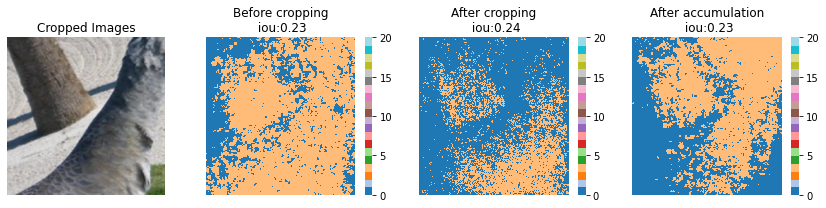

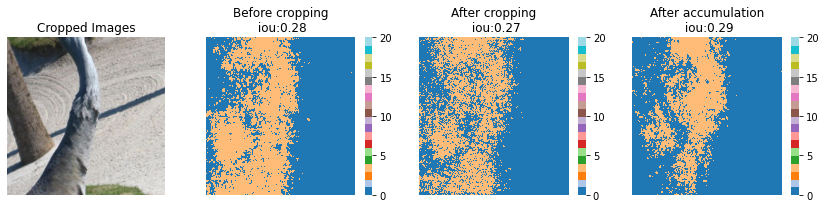

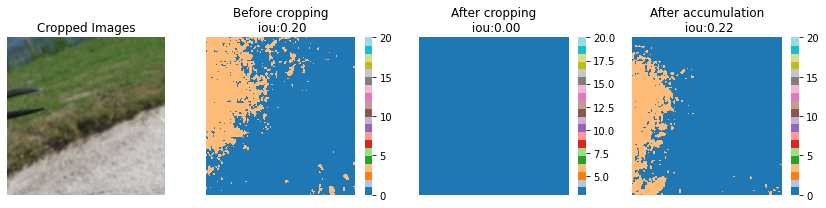

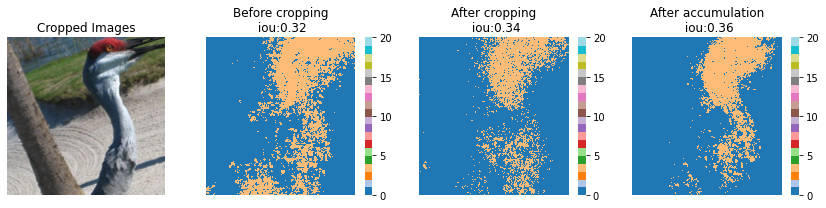

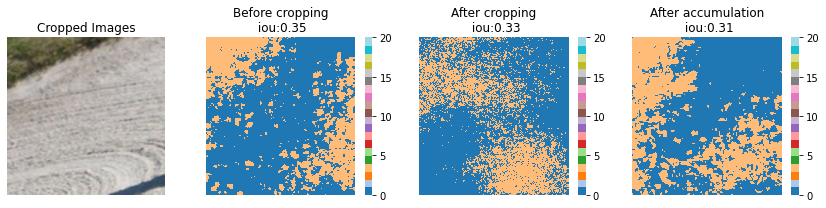

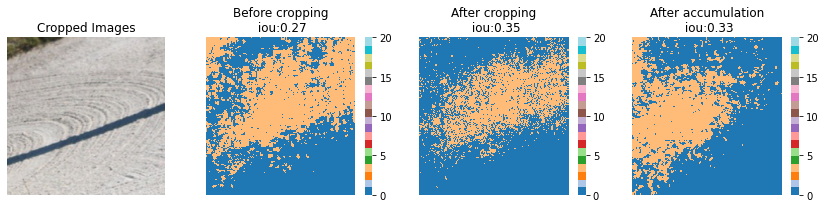

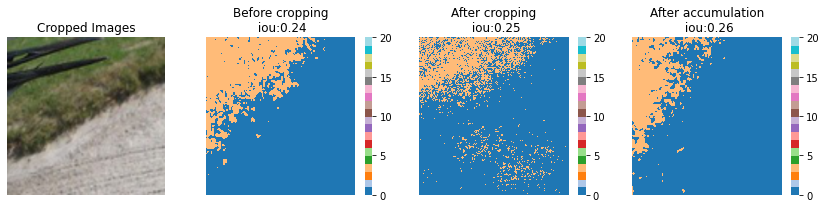

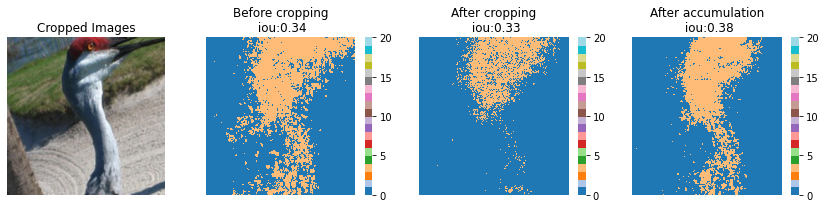

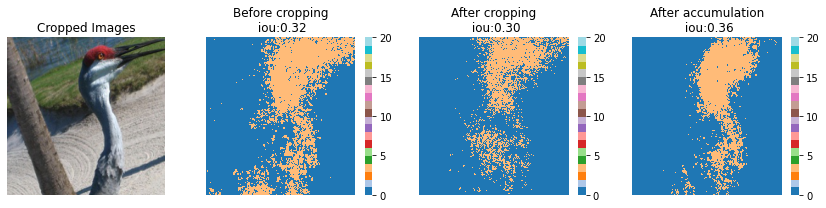

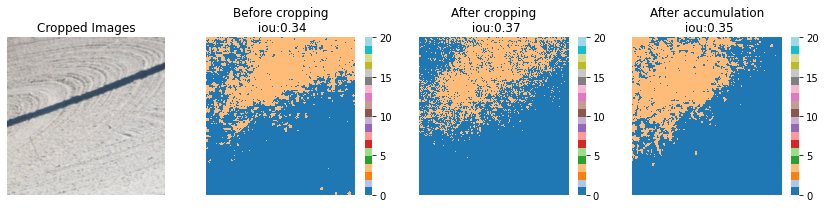

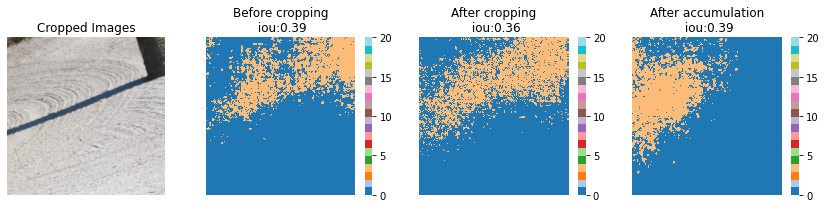

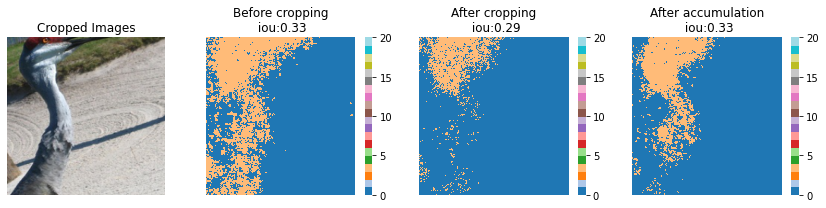

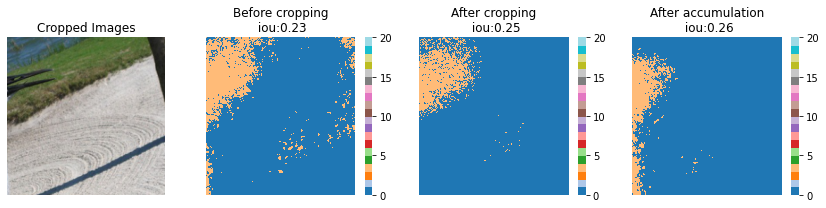

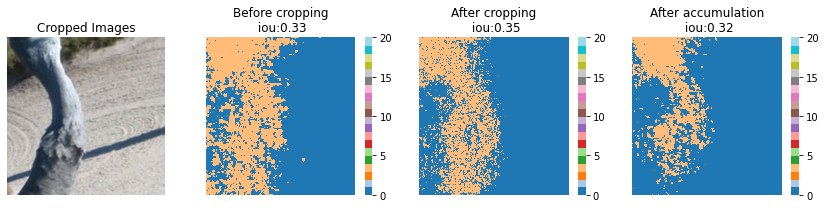

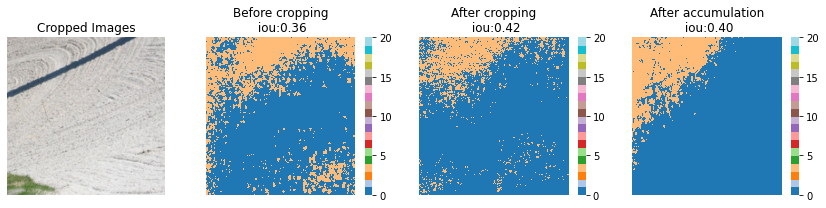

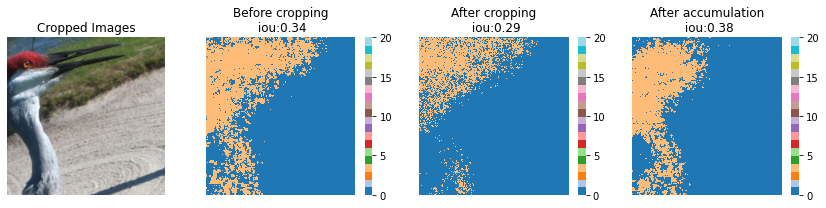

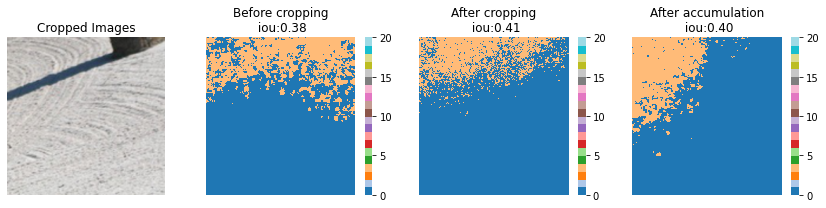

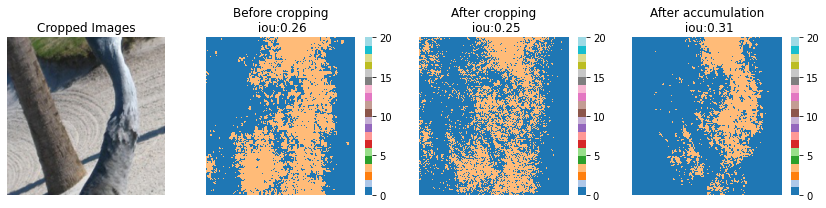

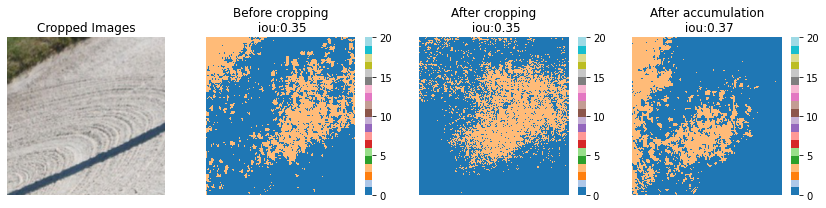

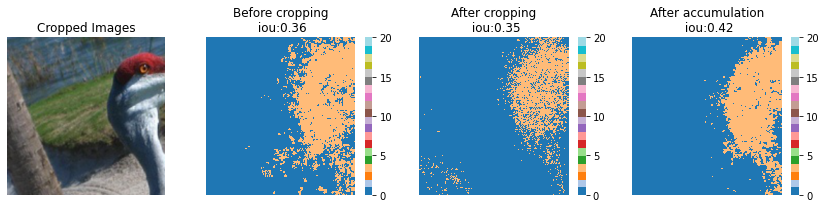

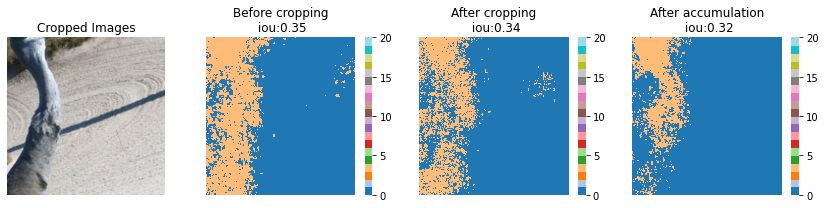

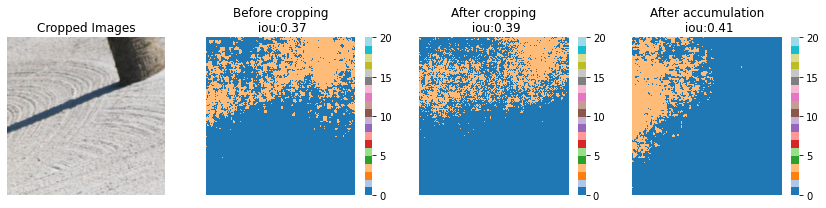

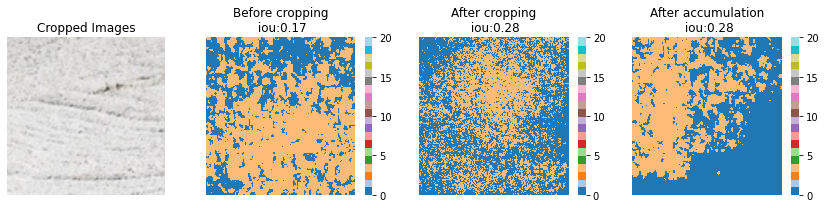

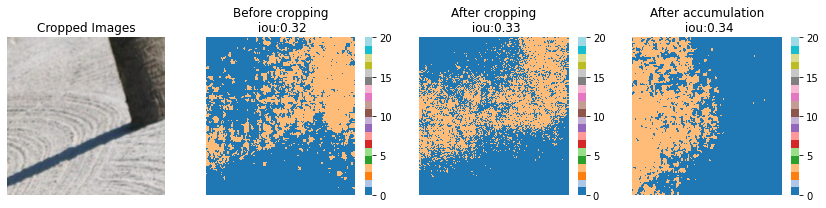

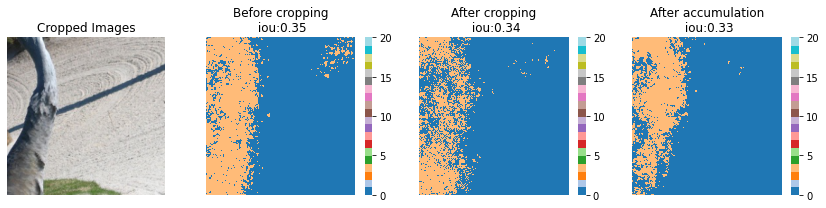

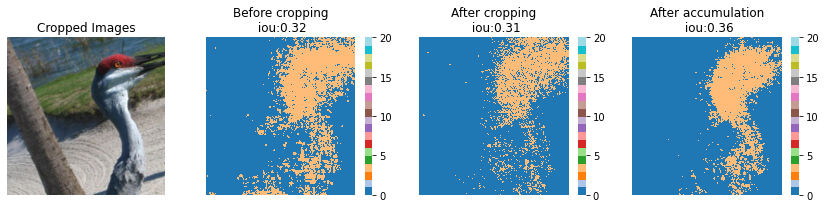

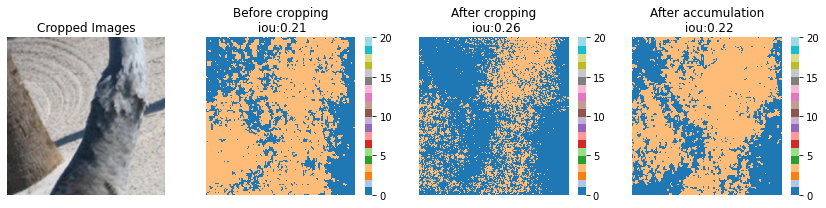

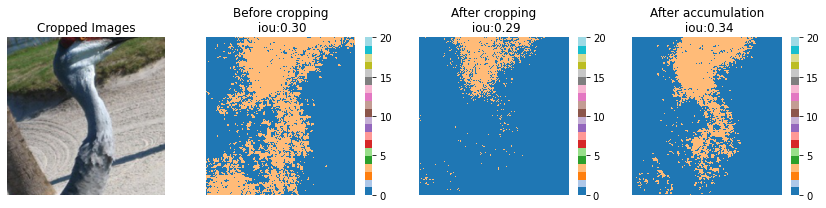

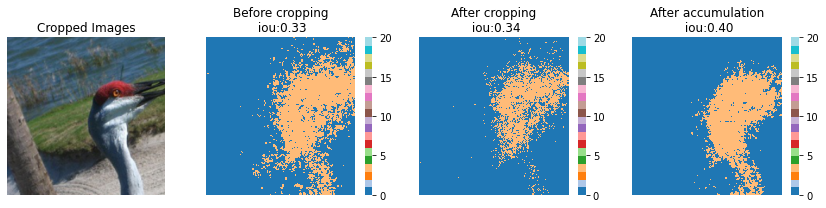

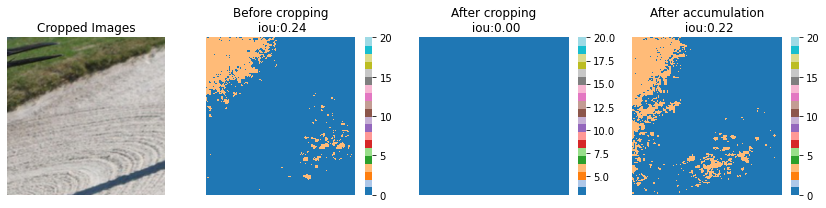

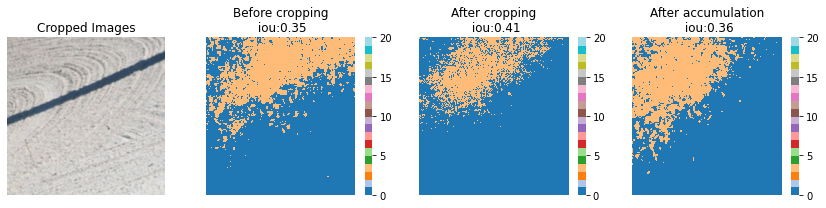

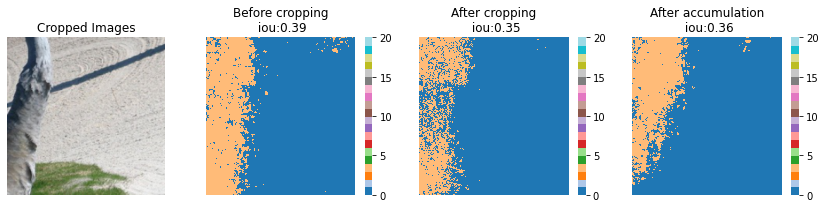

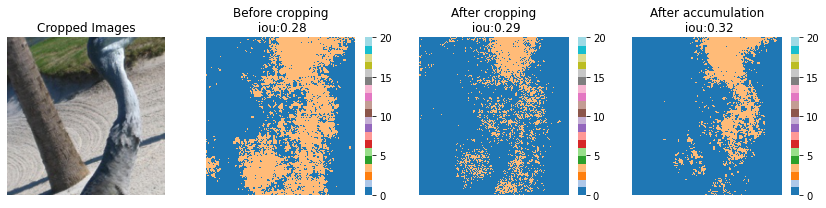

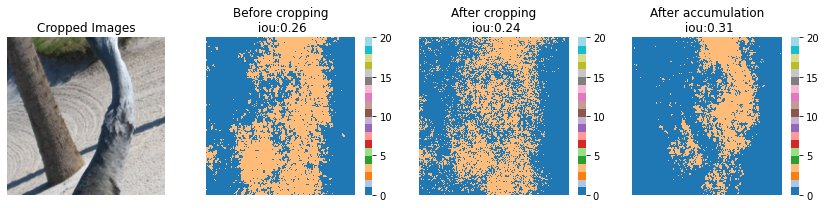

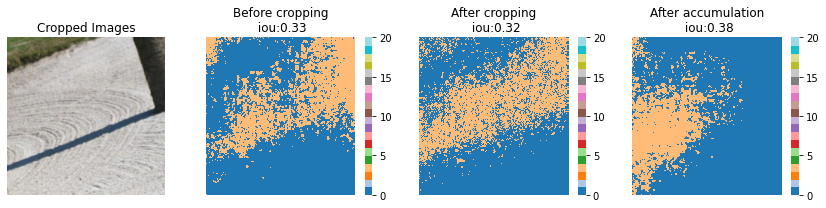

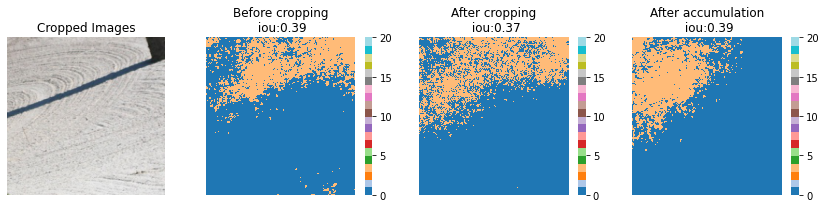

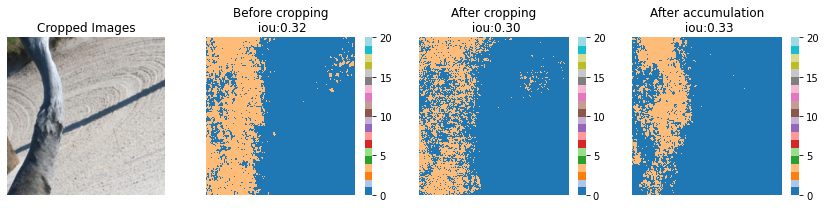

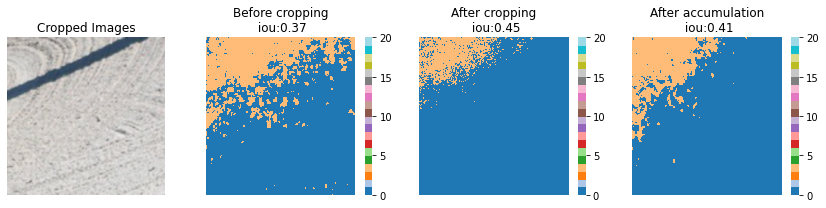

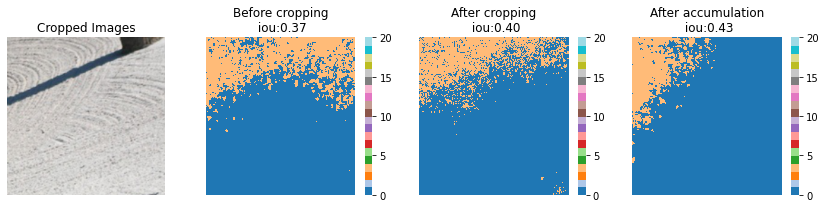

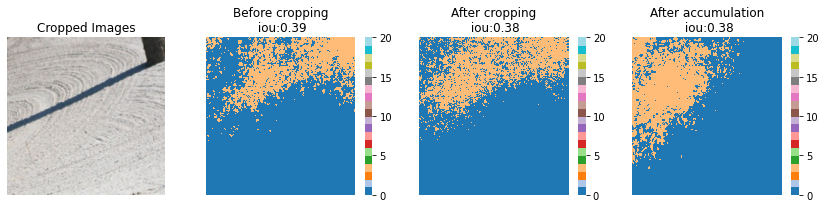

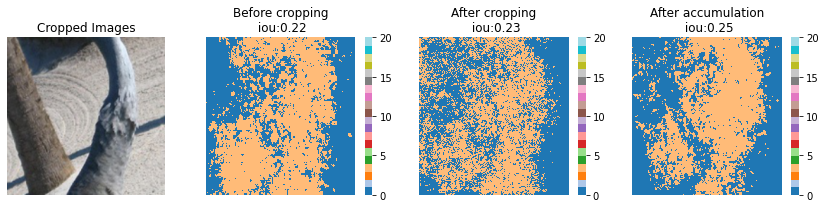

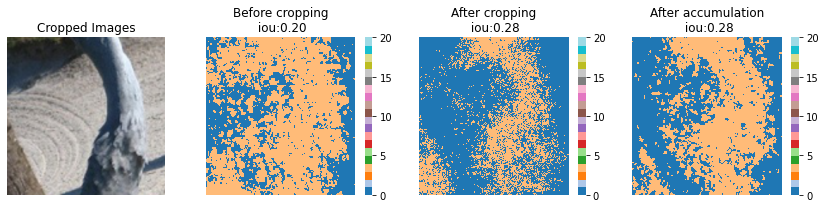

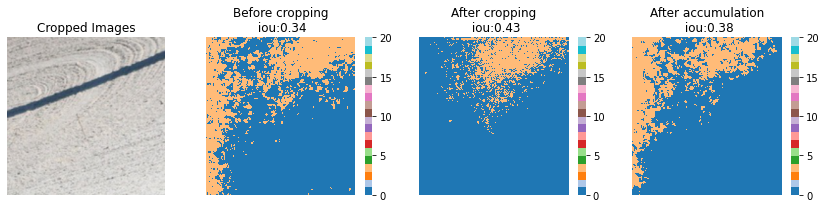

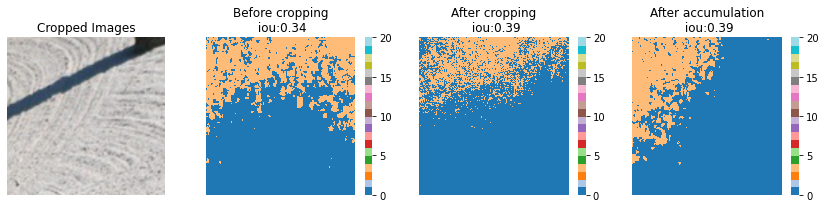

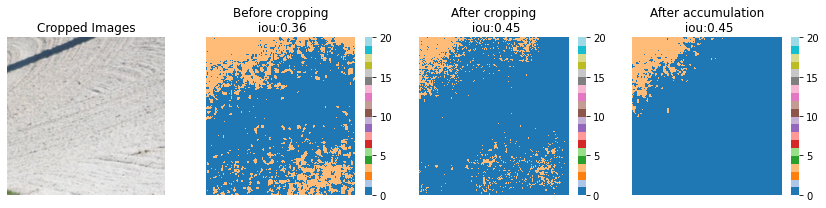

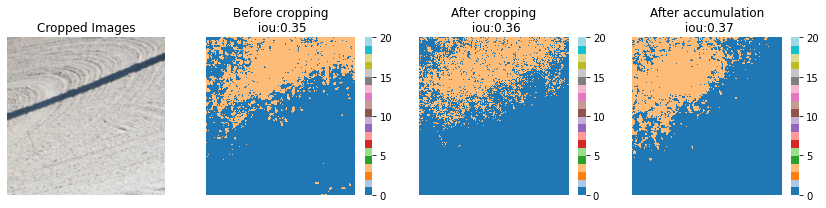

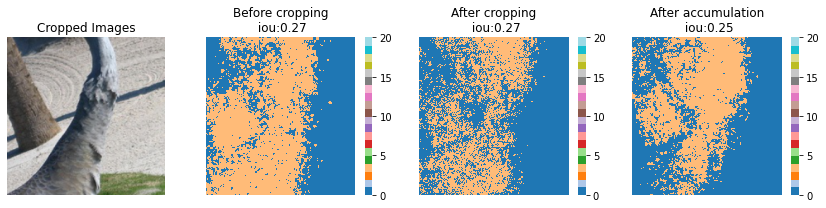

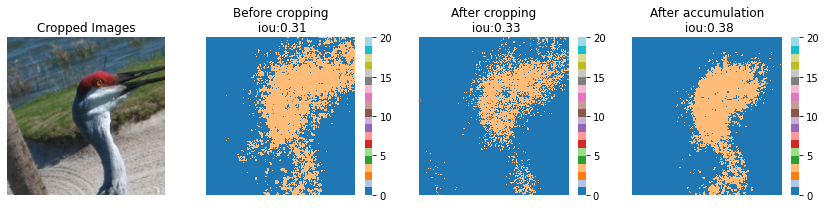

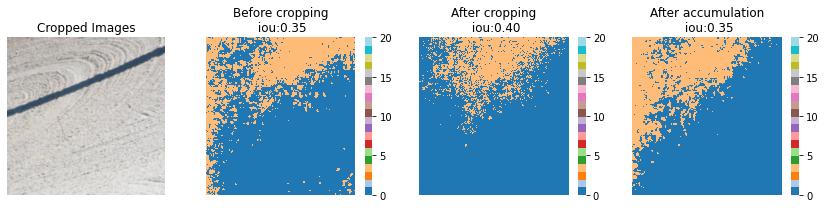

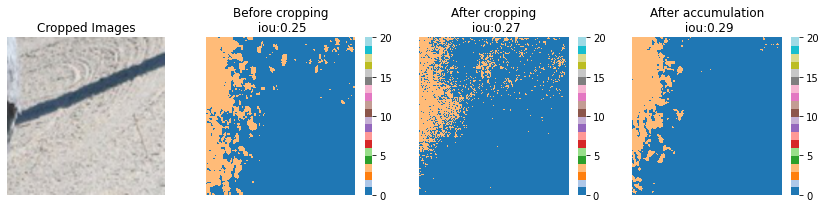

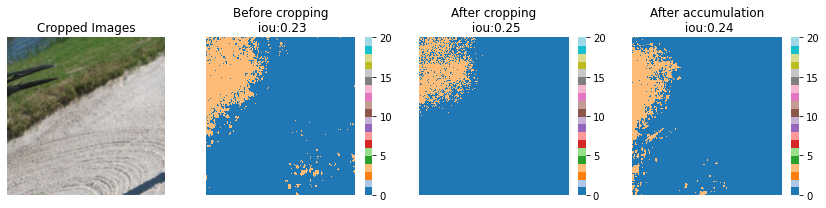

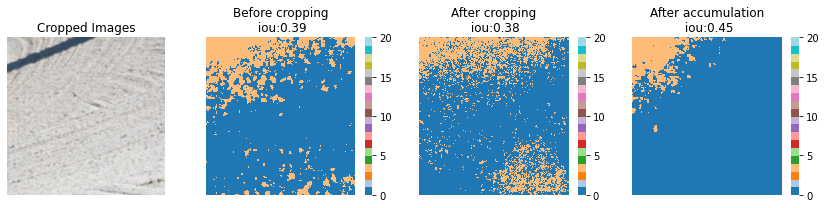

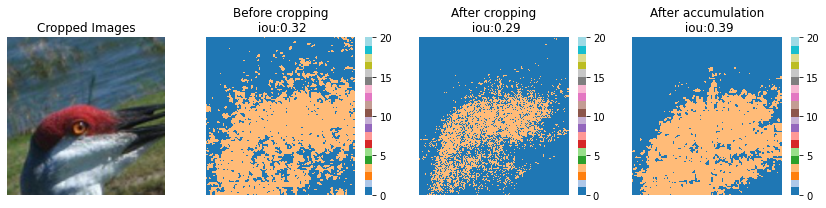

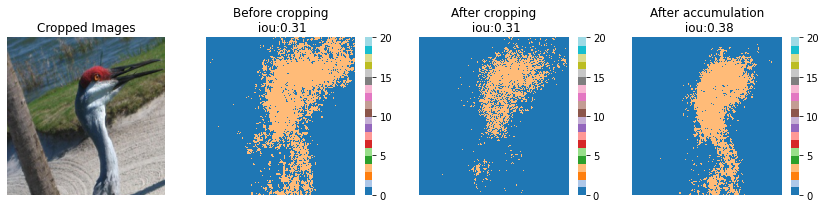

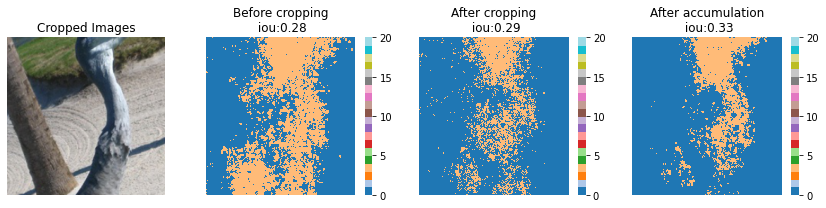

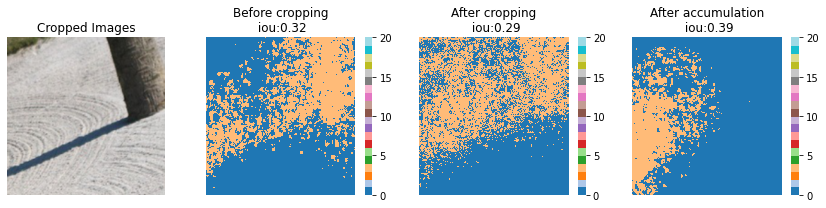

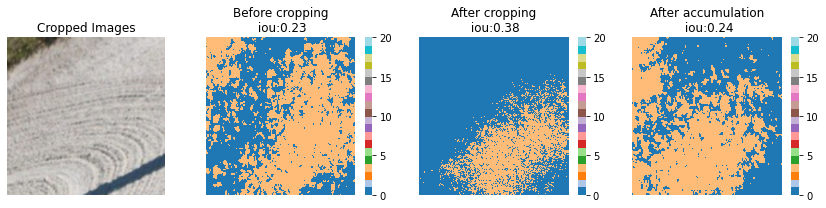

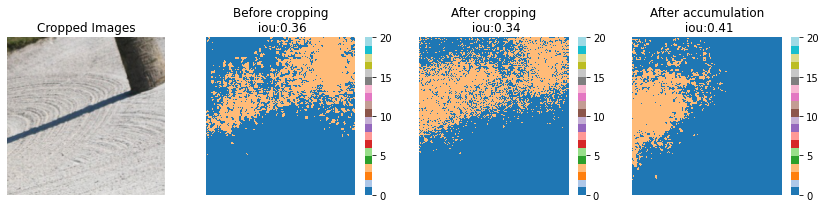

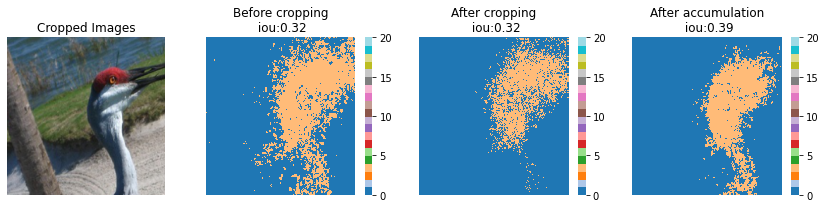

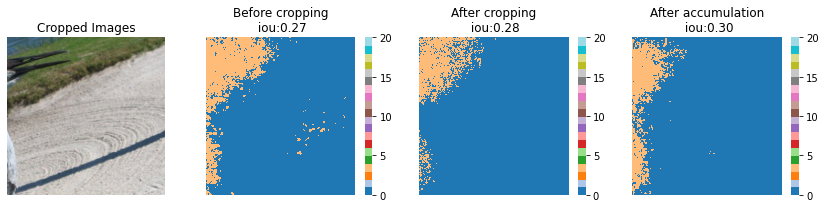

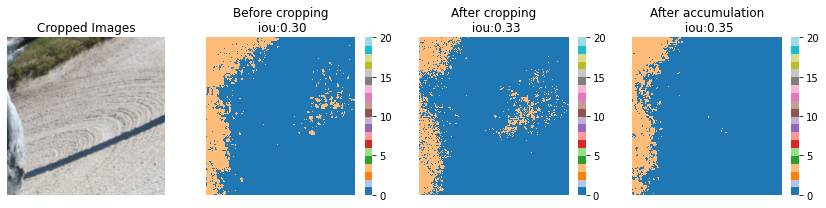

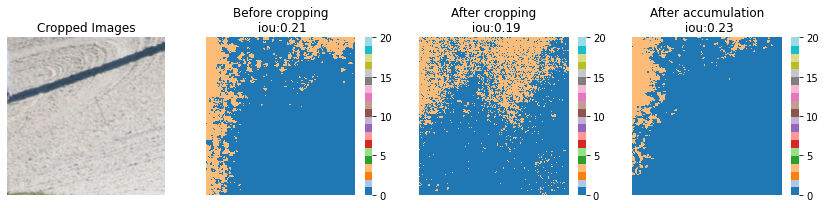

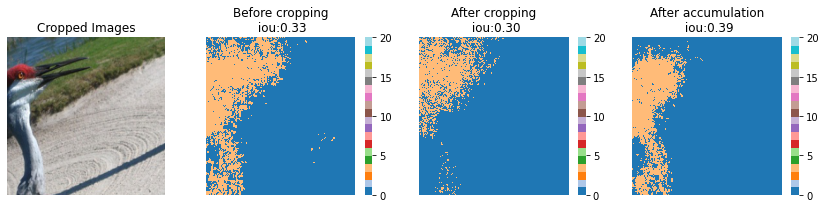

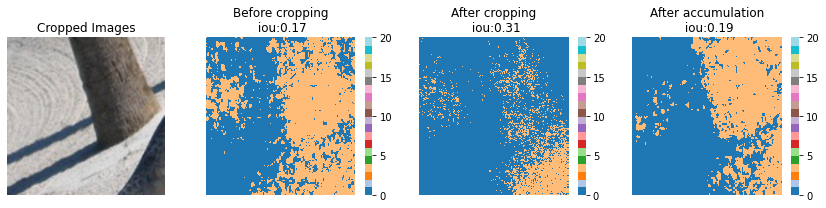

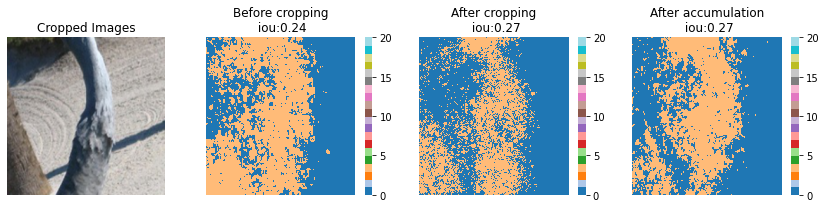

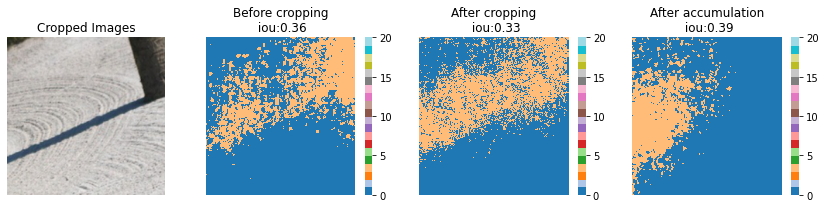

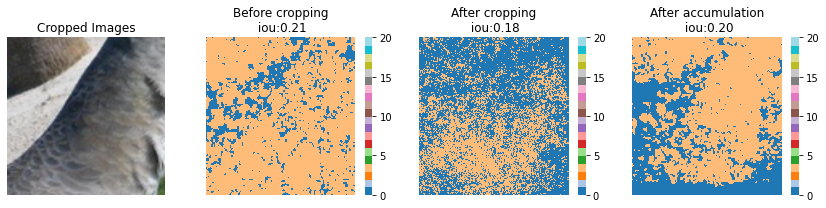

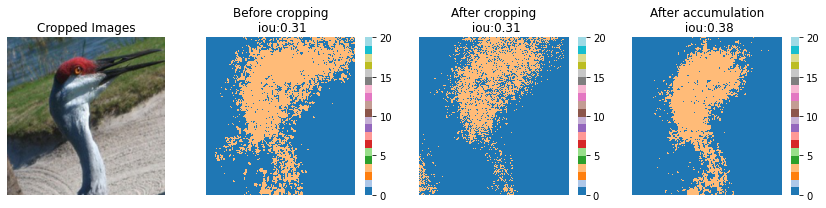

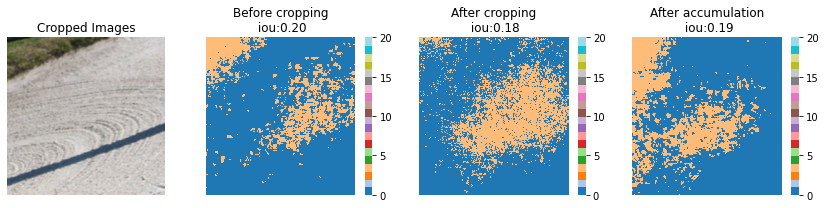

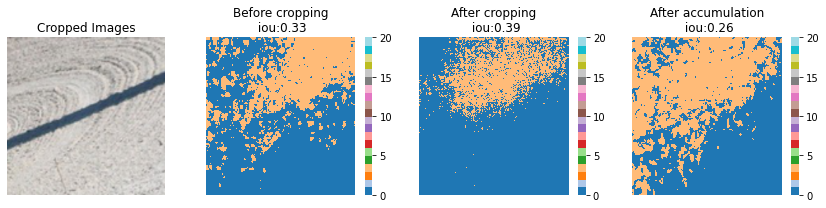

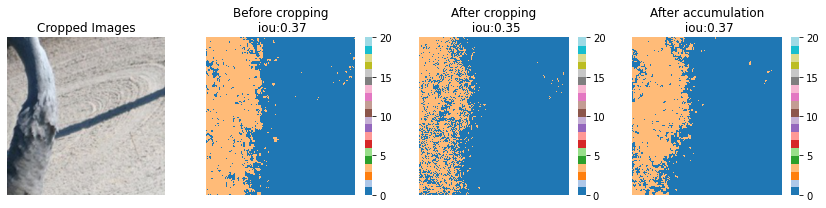

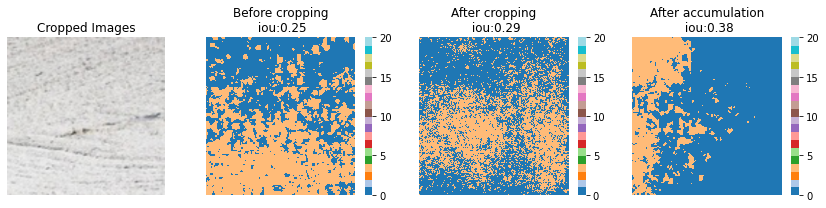

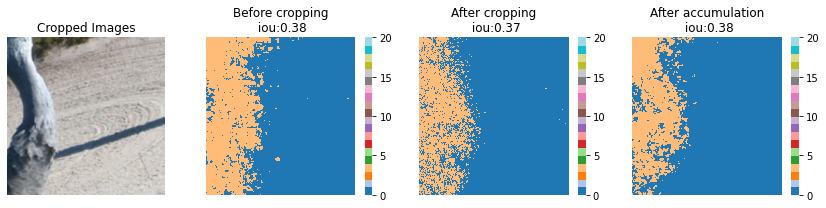

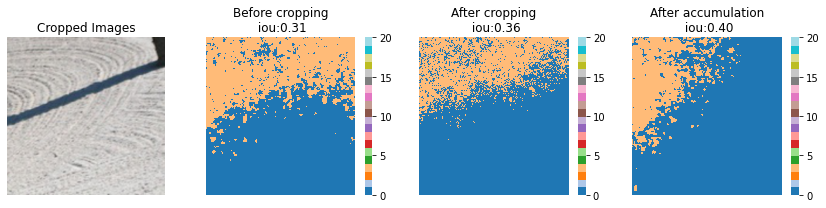

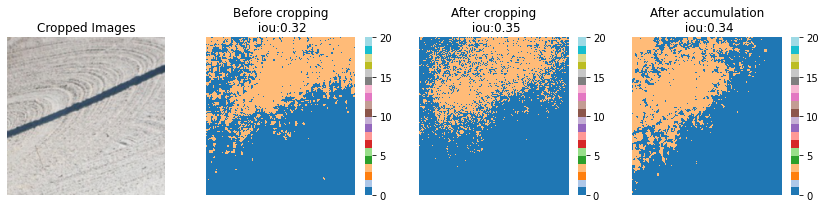

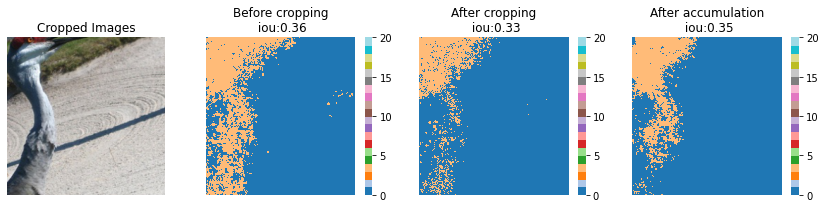

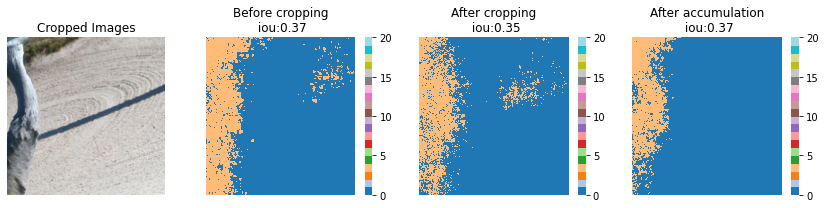

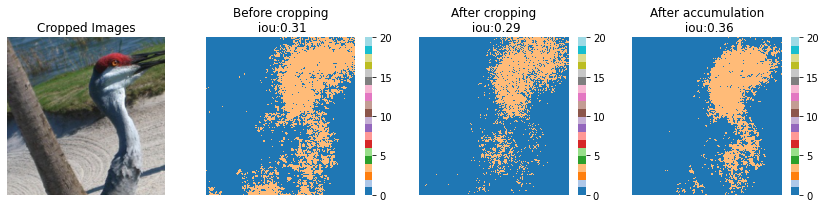

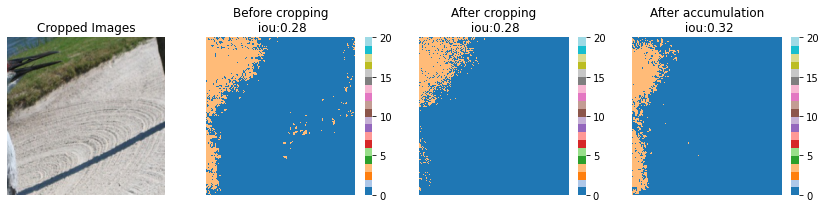

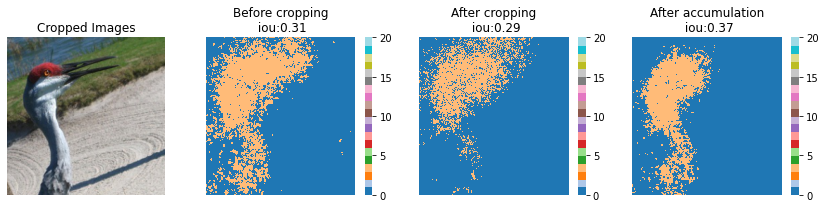

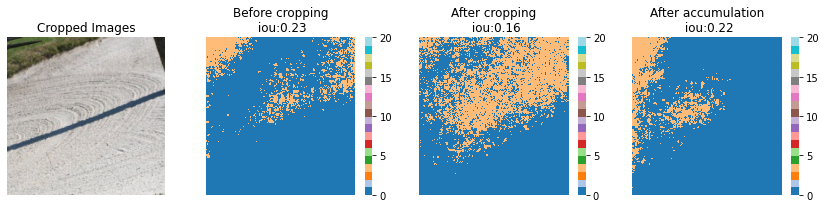

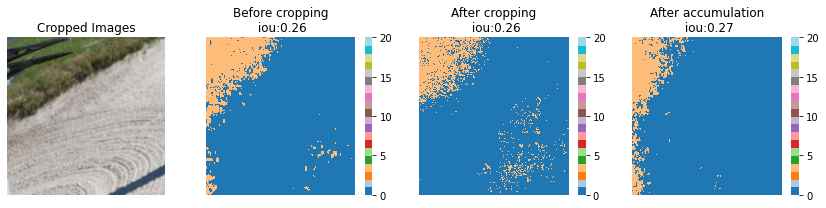

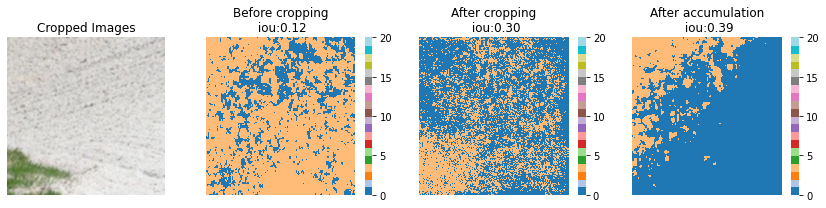

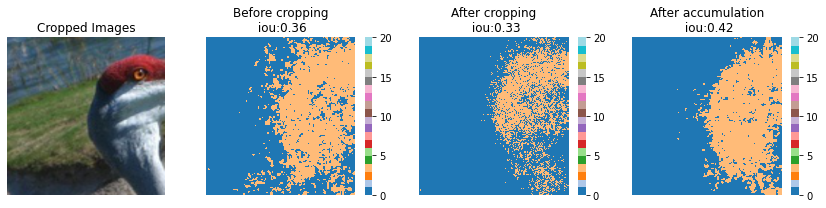

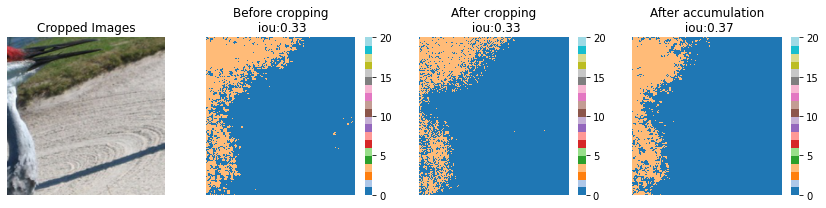

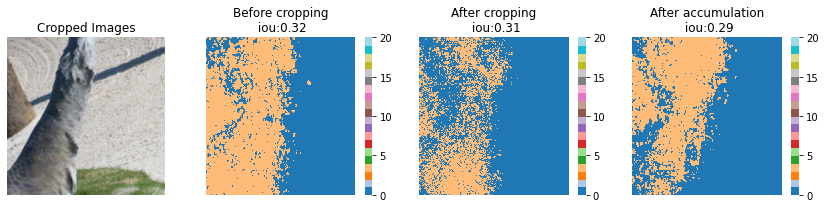

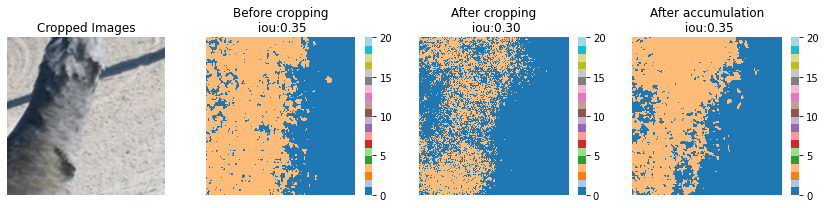

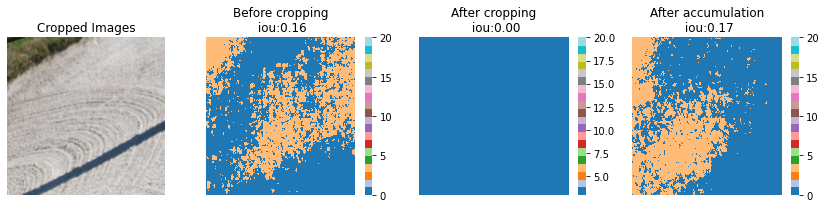

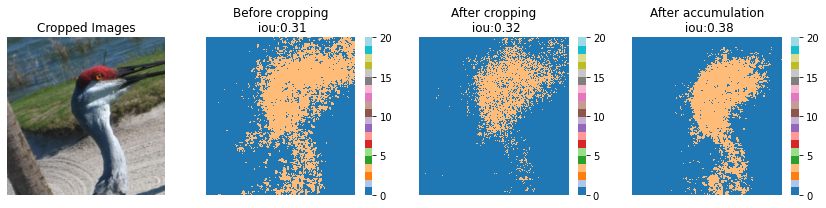

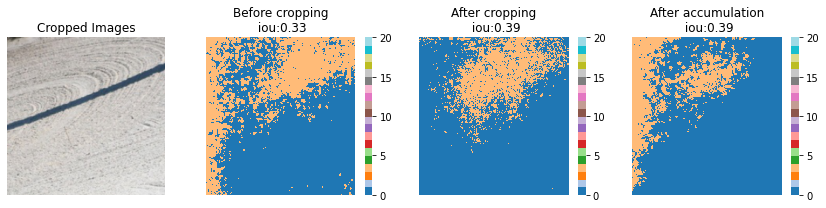

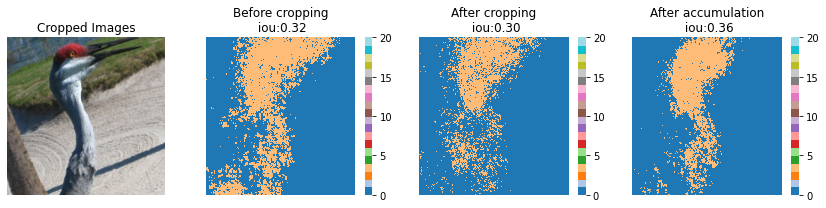

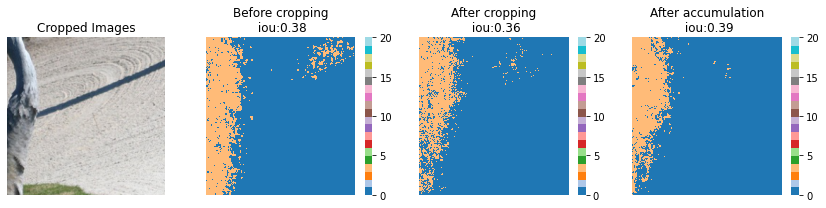

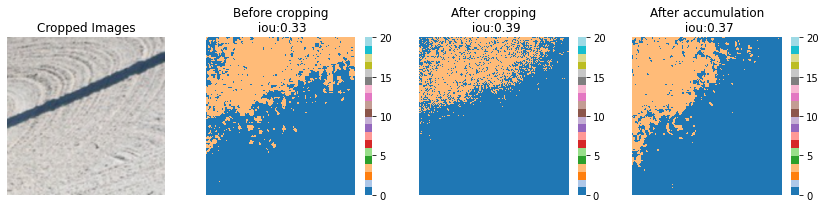

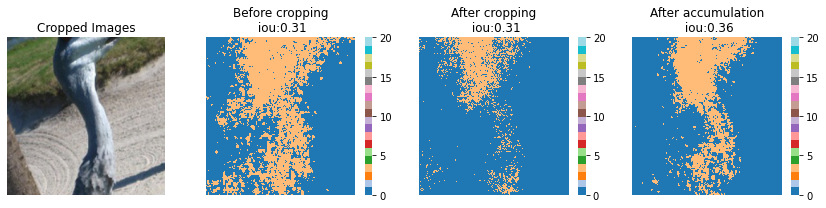

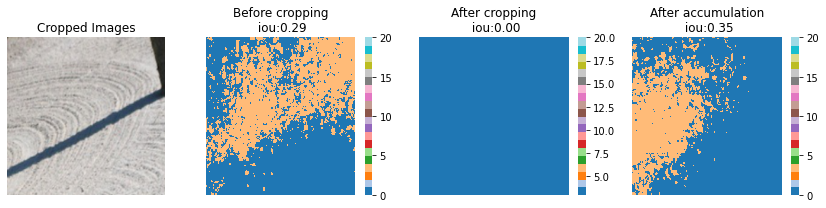

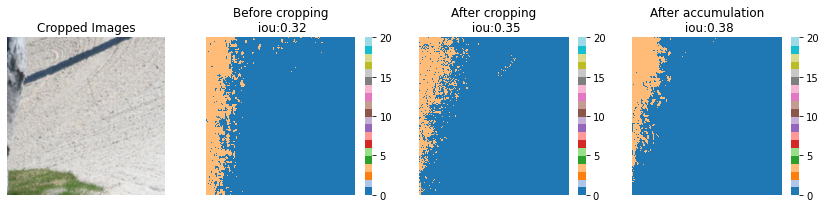

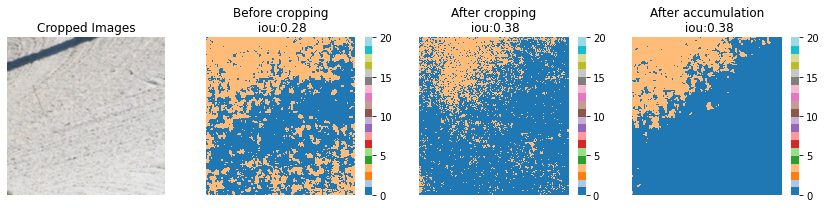

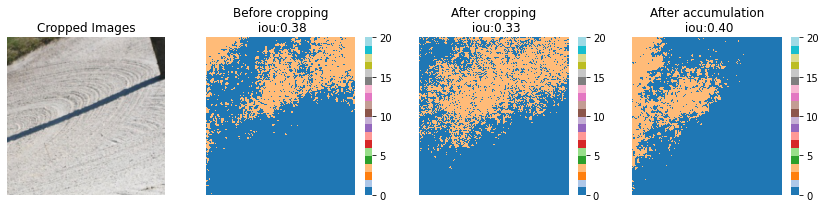

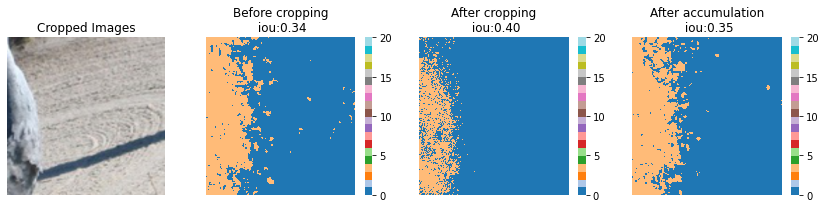

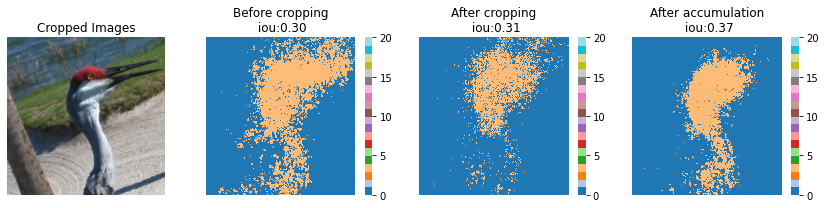

In [22]:
options = {
    'smoothing': False,
    'superpixel': False,
}

viz_first_n_saliencies(options, thres=0.15)

# Scatter Plots for mIOU

## For the bird image

Text(0.5, 1.0, 'after cropping vs accumulation')

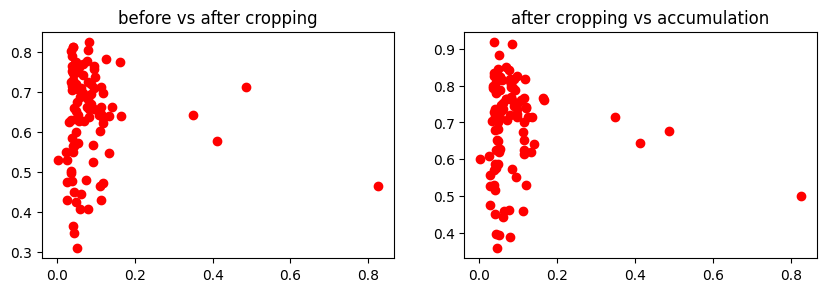

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3),dpi=100)
        
ax[0].scatter(x = miou_crops[i], y= miou_orig[3], color = 'red')
ax[0].set_title('before vs after cropping')

ax[1].scatter(x = miou_crops[i], y= miou_acc[3], color = 'red')
ax[1].set_title('after cropping vs accumulation')

### Before Cropping vs Cropping

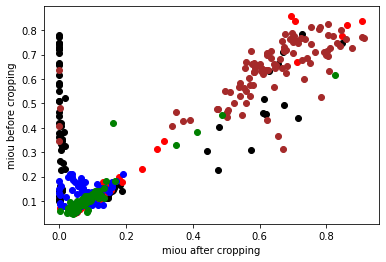

In [26]:
for i in range(no_of_images):
    if i ==0:
        c = 'black'
    elif i ==1:
        c= 'red'
    elif i ==2:
        c= 'blue'
    elif i ==3:
        c= 'brown'
    else:
        c = 'green'
        
    plt.scatter(x = miou_crops[i], y= miou_orig[i], color = c)
    
plt.xlabel("miou after cropping")
plt.ylabel("miou before cropping")
plt.show()

### After Accumulation vs Cropping

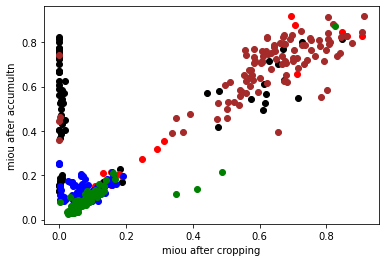

In [27]:
for i in range(no_of_images):
    if i ==0:
        c = 'black'
    elif i ==1:
        c= 'red'
    elif i ==2:
        c= 'blue'
    elif i ==3:
        c= 'brown'
    else:
        c = 'green'
        
    plt.scatter(x = miou_crops[i], y= miou_acc[i], color = c)
    
plt.xlabel("miou after cropping")
plt.ylabel("miou after accumultn")
plt.show()